# Installed packages and their versions (usefull for Docker )

In [1]:
! pip list

Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
alembic                            1.7.4
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopage                           0.4.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
b

In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import os
import datetime
import time
import math
import operator
import random
import gc
import numpy as np
print ('numpy', np.__version__)
import pandas as pd
print ('pandas', pd.__version__)
import pandasql as ps

from dateutil import relativedelta

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  train_test_split
from ipywidgets import FloatProgress

import json
print('json', json.__version__)
import warnings
import qgrid
import pickle
print ('pickle', pickle.format_version)
import shap as shap

import lightgbm as lgb
print ('lightgbm', lgb.__version__)

C:\Users\kyazi\anaconda3\python.exe
3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
numpy 1.20.1
pandas 1.2.4
json 2.0.9
pickle 4.0
lightgbm 3.2.1


# Define paths 

**The below assumes thatthis Jupyter notebook is opened directly from the "JupuyterNotebooks" directory**

**Besides this directory, there are three other directories "Data", "Objects" and "Reults"**

**All these four directories should be same-level directories under a common root directory**

**The location of the root directory itself is not important**

In [3]:
root_directory = os.path.dirname(os.getcwd())
PATH_DATA = root_directory + '\\Data\\'
PATH_OBJECTS = root_directory + '\\Objects\\'
PATH_RESULTS = root_directory + '\\Results\\'

# Load Data #

In [4]:
MISSING_VALUES = ['-','.']
DATES = []
_unicode = {}
dataset = 'PHASE2'
data = pd.read_csv(PATH_DATA + dataset + ".csv", encoding = 'utf-8', na_values = MISSING_VALUES, thousands = ',', sep = ',' 
                  ,  dayfirst = True, parse_dates = DATES,  dtype= _unicode )

#mask = data['CA_F_CASH_CARD_TG_CG'] == 'CG'
#data = data[mask]
#data = data.reset_index(drop = True)


def target_code(row):
    c = 0  # corresponds to 'no response'
    if row['FLAG_CLX_SIGNED_30D'] == 1:
        c = 1
    if row['CC_F_USE_30D'] == 1:
        c = 2
    return c


def To_Date(dt, dtime_input_format):
    
    if pd.isnull(dt):
        return np.datetime64('NaT')  #! it is key to have this and not np.NaN
    else: 
        dt = dt[:10]   
        dt = datetime.datetime.strptime( dt, dtime_input_format )
        if dt.year > 2021:   # <--in implementation, replace with datetime.date.today().year
            dt = dt.replace( year=dt.year-100 )
        return dt


data['target'] = data.apply(lambda row: target_code(row), axis =1)   
data['omni'] = 1
data['WT'] = 1

data['REPORT_DATE'] = data['REPORT_DATE'].apply(lambda x : To_Date(x, '%Y-%m-%d'))
data['month'] = data['REPORT_DATE'].dt.month

display(data.shape)
display(data['target'].value_counts())

(390496, 206)

0    389413
1       797
2       286
Name: target, dtype: int64

## Meta Data

In [5]:
col_target  = 'target'
col_month = 'month'
col_campaign = 'CA_TYPE'
col_weight = 'WT'

# Selection strategy based on a two-model based uplift metric 

## Load predictor lists

In [6]:
with open(PATH_OBJECTS + "predictors_CCX", "rb") as f:   #shap ordered
    predictors_CCX = pickle.load(f)
    
with open(PATH_OBJECTS + "predictors_CLX", "rb") as f:  #shap ordered
    predictors_CLX = pickle.load(f)

predictors = set(predictors_CCX).union(set(predictors_CLX))  #unpredictable order
predictors = list(predictors)
predictors = sorted(predictors) #alphabeticaly ordered

G = pd.DataFrame(data[predictors].dtypes)
G.rename(columns = {0:'type'}, inplace = True)
mask = (G['type'] =='category') | (G['type'] =='object')

_cols_pred_cat = list(G[mask].index)

for col in _cols_pred_cat:
    data[col] = data[col].astype('category')
    
predictors = [p for p in predictors if p not in ['CA_TYPE']]
_cols_pred_cat = [p for p in _cols_pred_cat if p not in ['CA_TYPE']]

In [7]:
print(len(predictors))
print(len(_cols_pred_cat))

119
13


## Load pretrained models 

In [8]:
model_CCX = lgb.Booster(model_file= PATH_OBJECTS + "model_CCX_CG")
model_CLX = lgb.Booster(model_file= PATH_OBJECTS + "model_CLX_CG")

## Calculate Uplift (on control group part) ##

### Restrict to control group observations 

In [9]:
# Choose only control group records
mask = data['CA_F_CASH_CARD_TG_CG'].isin(['CG'])

df = data[mask]
df = df.reset_index(drop = True)

overall_response = 100*df[df[col_target] != 0].shape[0]/df.shape[0]
Cash_response = 100*df[df[col_target] == 1].shape[0]/df.shape[0] 
Card_response = 100*df[df[col_target] == 2].shape[0]/df.shape[0] 

### Score the evaluation data set with each model 

In [10]:
pd_positive_CCX = 1-model_CCX.predict(df[predictors], num_iteration = model_CCX.best_iteration)[:,0]
pd_positive_CLX = 1-model_CLX.predict(df[predictors], num_iteration = model_CLX.best_iteration)[:,0]

### Calculate uplift  and bin it into n_bins equifrequent intervals

Get log of the ratio of probabilities of a positive response ( regardless Cash or CCX) from the two scores:

**uplift = log (Pd(Cash or Card| CCX)/ Pd(Cash or Card |CLX))**

The higher this value, the higher is the effectiveness of CCX channel against CLX channel in securing a response (Cash or Card)

Sort test data according to this value and devide into 20 equifrequent groups (each is 5 %)

In [11]:
uplift = np.zeros(len(pd_positive_CCX))

for i in range(len(pd_positive_CCX)):
    uplift[i] = math.log(pd_positive_CCX[i]/pd_positive_CLX[i])
    
df['uplift'] = uplift

n_bins = 20

interval_index = pd.qcut(df['uplift'], n_bins ,duplicates='drop').values.__dict__['_dtype'].__dict__['_categories']
bins =[interval_index[0].left]
for i in np.arange(0, len(interval_index)):
    bins.append(interval_index[i].right)

df['bin']  =     pd.cut(round(df['uplift'],3), bins, labels = False, right = True, retbins=False)
df['labels']  =  pd.cut(round(df['uplift'],3), bins, labels = interval_index)

In [12]:
BINS = sorted(list(df['bin'].value_counts().index))
BINS.append(20)
display(BINS)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

### Show bin definitions based on the logodds metric

In [13]:
POP = df.groupby(['bin'], sort = True).apply(lambda dfx: dfx['omni'].sum())/df.shape[0]
G = df[['bin','labels']].drop_duplicates()
G.sort_values(by = 'bin', inplace = True)
G.rename(columns = {'labels' : 'uplift_range'}, inplace = True)
G['POP%'] = POP.values
G.to_excel('Goverall.xlsx')
display(G)

,bin,uplift_range,POP%
42,0,"(-2.441, -0.649]",0.050116
15,1,"(-0.649, -0.459]",0.050016
20,2,"(-0.459, -0.333]",0.050016
24,3,"(-0.333, -0.233]",0.050190
1,4,"(-0.233, -0.149]",0.050164
10,5,"(-0.149, -0.0738]",0.049711
22,6,"(-0.0738, -0.00421]",0.049560
8,7,"(-0.00421, 0.0618]",0.050011
5,8,"(0.0618, 0.126]",0.050646
26,9,"(0.126, 0.189]",0.050146


# Evaluate strategies for various logodds range cutoffs

In [14]:
df = df[['uplift', 'CA_TYPE', col_target]]

## Bootstrap evaluation data set

In [15]:
BTSTRP = {}

f = FloatProgress(description='Progress:', min = 0, max =100)
display(f)

for k in np.arange(0,101):
    BTSTRP[k] = pd.DataFrame()
    n= df.shape[0]
    right = pd.DataFrame(index=np.random.randint(n, size=n))
    bootstrap = pd.merge(df, right, left_index=True, right_index=True, how='right')
    # apply binning according to bin boundaries derived from original df (non bootstrapped)
    bootstrap['bin']  =     pd.cut(round(bootstrap['uplift'],3), bins, labels = False, right = True, retbins=False)
    BTSTRP[k] = BTSTRP[k].append(bootstrap)
    f.value +=1

FloatProgress(value=0.0, description='Progress:')

## Apply uplift based  partitioning scenario for each bootstrap

For each bootstarp version of the data :

    Assume a parttioning scenario where we use only CCX as the initial channel in the top X% of the data according to the uplift metric.For the remaining 1-X% , assume we use only CLX as the initial channel (e.g. top 55% will include bins 9 through 19 as depicted in the table, and the remaining 45% will correspond to bins 0 through 8).

    Now for each of the three response CATEGORIES (Card, Cash, Card or Cash) the following will hold under this scenario:

    -The average CATEGORY response rate in the top X%  will equal the CATEGORY's empirical response rate in that 
    part of the data using only cases that were actually addressed with CCX first.  Denote this rate as  Rccx

    -The average CATEGORY response rate in the remaining 1-X% is the CATEGORY's empricial response rate in that part of the data using only cases that were actually addressed with CLX first.  Denote this rate as  Rclx

    -The total CATEGORY's response rate in the full data will then equal : X.Rccx + (1-X).Rclx

     Repeat this for various levels of X from 0 to 100 (step by 5) and log those response rates and log those total responding rates.

In [16]:
def Response_overall(df, cutoff):

    mask_CCX = (df['bin'] >= cutoff) &  (df['CA_TYPE'] == 'CCX')
    mask_CLX = (df['bin'] <  cutoff)  & (df['CA_TYPE'] == 'CLX')    

    if cutoff == 0: #ALL CCX
        Response_CCX = 100*df[mask_positive_response & mask_CCX].shape[0]/df[mask_CCX].shape[0]
        size_CCX = df[df['bin'] >= cutoff].shape[0]/df.shape[0]
        
        R = Response_CCX*size_CCX

    if cutoff == 20: #All CLX
        Response_CLX = 100*df[mask_positive_response & mask_CLX].shape[0]/df[mask_CLX].shape[0]
        size_CLX = df[df['bin'] < cutoff].shape[0]/df.shape[0]
        
        R =  Response_CLX*size_CLX   

    if (cutoff > 0) and (cutoff < 20):
        
        Response_CCX = 100*df[mask_positive_response & mask_CCX].shape[0]/df[mask_CCX].shape[0]
        size_CCX = df[df['bin'] >= cutoff].shape[0]/df.shape[0]

        Response_CLX = 100*df[mask_positive_response & mask_CLX].shape[0]/df[mask_CLX].shape[0]
        size_CLX = df[df['bin'] < cutoff].shape[0]/df.shape[0]
        
        R = Response_CCX*size_CCX + Response_CLX*size_CLX
    
    return R

In [17]:
current_response_overall = {}
current_response_Card = {}
current_response_Cash = {} 

response_Cash_Card = {}
response_Card = {}
response_Cash = {}

current_response_overall[0] = {}
current_response_Card[0] = {}
current_response_Cash[0] = {} 

response_Cash_Card[0] = {}
response_Card[0] = {}
response_Cash[0] = {}

f = FloatProgress(description='Progress:', min = 0, max =101)
display(f)

for key in BTSTRP.keys():
        
    current_response_overall[0][key] = {}
    current_response_Card[0][key] = {}
    current_response_Cash[0][key] = {} 
    
    r = 100*BTSTRP[key][BTSTRP[key][col_target] != 0].shape[0]/BTSTRP[key].shape[0]
    current_response_overall[0][key] = np.full(len(BINS), r)
    
    r = 100*BTSTRP[key][BTSTRP[key][col_target] == 2].shape[0]/BTSTRP[key].shape[0] 
    current_response_Card[0][key] = np.full(len(BINS), r)
    
    r = 100*BTSTRP[key][BTSTRP[key][col_target] == 1].shape[0]/BTSTRP[key].shape[0] 
    current_response_Cash[0][key]= np.full(len(BINS), r)
    
    response_Cash_Card[0][key] = {}
    response_Card[0][key] = {}
    response_Cash[0][key] = {}

    for cutoff in BINS:
        
        mask_positive_response = BTSTRP[key][col_target] != 0
        response_Cash_Card[0][key][cutoff] = Response_overall(BTSTRP[key],cutoff)

        mask_positive_response = BTSTRP[key][col_target] == 2
        response_Card[0][key][cutoff] = Response_overall(BTSTRP[key],cutoff)

        mask_positive_response = BTSTRP[key][col_target] == 1
        response_Cash[0][key][cutoff] = Response_overall(BTSTRP[key],cutoff)
        
    f.value +=1


FloatProgress(value=0.0, description='Progress:', max=101.0)

## Evaluate results ( response change curves (vs. status-quo) ) and determine optimal cutoff bin

Once finished, take various statistics of the response across the bootstraps ( lower quantile, median , mean, higher quamtile).

Find the X corresponding to the case, where the  mean **Cash** response rate under the above strategy is as close as possible (statistically the same) to the "normal, no-scenario, status-quo"  mean **Cash** repsonse rate (i.e. the simple Cash reponse rate in the data regardless which initial strategy was used). Then take the corresponding bin for that X and that will define the uplift cutoff value above which a case will be always adressed by **CCX** first and below which it will be addressed by **CLX** first (e.g. if the optimal X was 55%, then the corresponding bin will be bin # 9 in the table. This means that any future case where the uplift will be > -0.0158 will be sent to CCX first and any case where the uplift will be <= -0.0158 will be sent to CLX first). 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


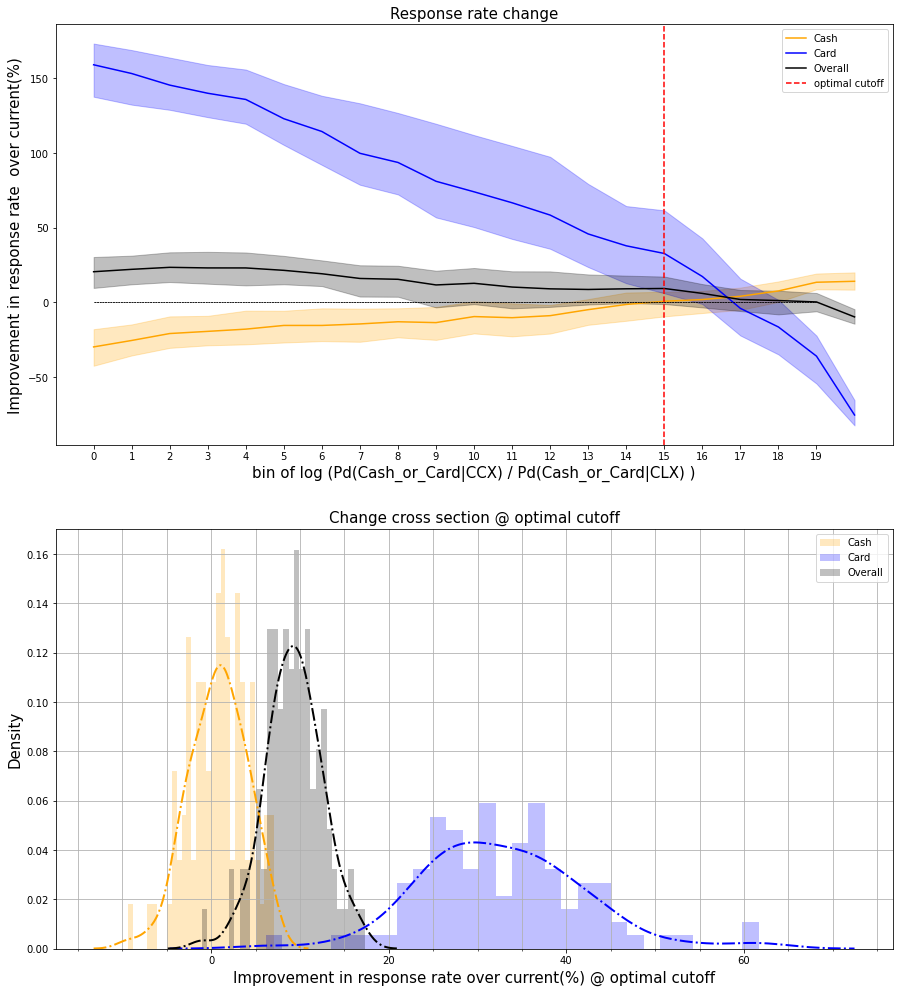

In [32]:
#label = 'Overall'
#label = 'Cash'
label = 'Card'

same = np.zeros(len(G))

def Imp(label):

    if label == 'Cash':
        _color = 'orange'
        _label = 'Cash'
        A  = pd.DataFrame(response_Cash[0])
        B  = pd.DataFrame(current_response_Cash[0])

    if label == 'Card':
        _color = 'blue'
        _label = 'Card'
        A  = pd.DataFrame(response_Card[0])
        B  = pd.DataFrame(current_response_Card[0])

    if label == 'Overall':
        _color = 'black'
        _label = 'Overall'
        A  = pd.DataFrame(response_Cash_Card[0])
        B  = pd.DataFrame(current_response_overall[0])
    
    Improvement =  100*(A.divide(B)-1)
    
    return Improvement, _color, _label

_aplha = 0.25
fig = plt.figure(figsize = (15,17))
gs = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

ax1.set_title('Response rate change', fontsize = 15)
ax1.set_ylabel('Improvement in response rate  over current(%)', fontsize = 15)
ax1.set_xlabel('bin of log (Pd(Cash_or_Card|CCX) / Pd(Cash_or_Card|CLX) )', fontsize = 15)

ax2.set_title('Change cross section @ optimal cutoff', fontsize = 15)
ax2.set_ylabel('Density', fontsize = 15)

from matplotlib.ticker import MultipleLocator

spacing = 5 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
ax2.xaxis.set_minor_locator(minorLocator)

_lowerquantile = 0
_upperquantile = 1

for label in ['Cash', 'Card', 'Overall']:

    Improvement, _color, _label = Imp(label)
    
    q2Improvement = Improvement.quantile(q =_lowerquantile, axis =1)
    q50Improvement = Improvement.quantile(q =0.5, axis =1)
    meanImprovement = Improvement.mean(1)
    q98Improvement = Improvement.quantile(q =_upperquantile , axis =1)
    STAT = pd.concat([q2Improvement,q50Improvement,q98Improvement], axis =1)
    STAT.rename(columns = {_lowerquantile : 'LQ'}, inplace = True)
    STAT.rename(columns = {_upperquantile : 'UQ'}, inplace = True)
    STAT = pd.concat([STAT,meanImprovement], axis =1)
    STAT.rename(columns = {0.0: 'mean'}, inplace = True)    

    ax1.plot(STAT['mean'] , color = _color, label = _label)
    ax1.plot(same, color = 'black', linestyle = '--', linewidth = 0.5)
    ax1.fill_between(STAT.index, STAT['LQ'], STAT['UQ'], color =_color, alpha = _aplha)
    
    if label == 'Cash':
        # The optimal bin corresponds to minimum change in cash response compared to incumbent (criterion defined by business)
        optimal_bin = abs(meanImprovement).idxmin()
        #optimal_bin = abs(q98Improvement).idxmin()
    
    #override automatic optimal_bin (manual setup)
    #optimal_bin = 12
    
    if label == 'Cash':
        _color = 'orange'
    if label == 'Card':
        _color = 'blue'
    if label == 'Overall':
        _color = 'black'
        
    sns.distplot(Improvement.iloc[optimal_bin], bins = 30,  kde_kws={'linewidth': 2, 'linestyle': 'dashdot', "color": _color},\
                    hist_kws={"linewidth": 1, "alpha": _aplha , "color": _color}, label = label , ax = ax2)
    
    ax2.set_xlabel('Improvement in response rate over current(%) @ optimal cutoff', fontsize = 15)
        
ax1.axvline(x = optimal_bin, color='red', linestyle='--', label = 'optimal cutoff')
ax1.set_xticks(G['bin'])
ax1.legend()
ax2.grid(which = 'both')
ax2.legend()
plt.savefig(PATH_RESULTS +'Improvements.png')
plt.show()

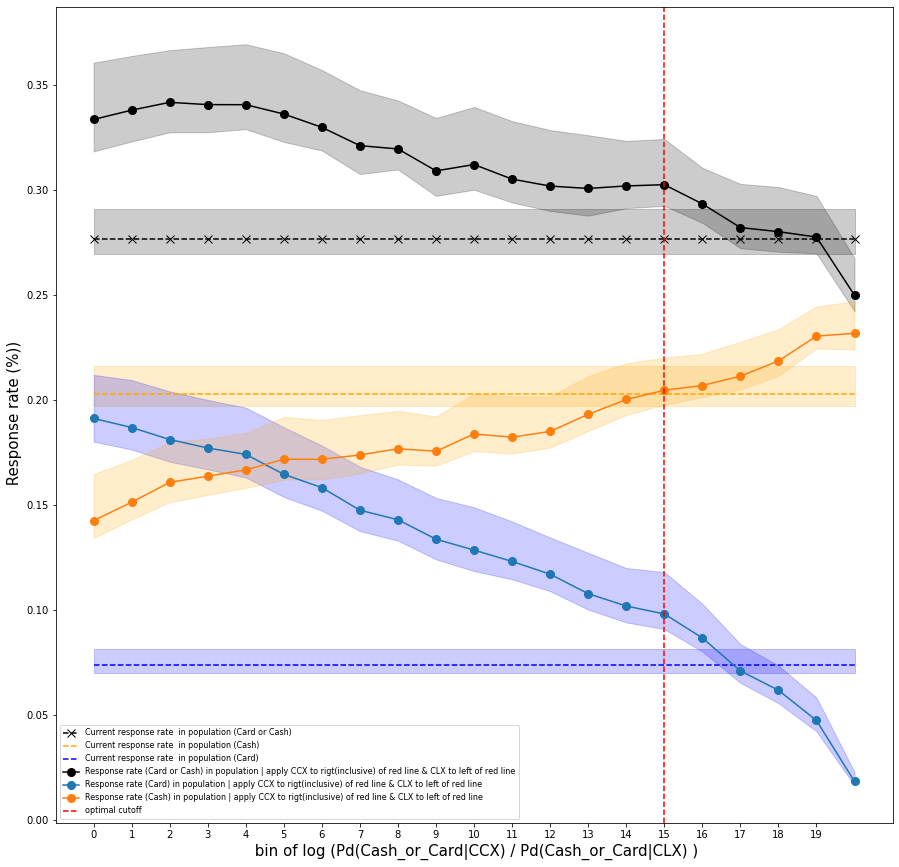

In [19]:
fig = plt.figure(figsize = (15,15))

gs = gridspec.GridSpec(1, 1)

#[current]
CashCardR = pd.DataFrame(current_response_overall[0])
q2CashCardR = CashCardR.quantile(q =0.2, axis =1)
meanCashCardR = CashCardR.mean(1)
q98CashCardR = CashCardR.quantile(q =0.98, axis =1)

CardR = pd.DataFrame(current_response_Card[0])
q2CardR = CardR.quantile(q =0.2, axis =1)
meanCardR = CardR.mean(1)
q98CardR = CardR.quantile(q =0.98, axis =1)

CashR = pd.DataFrame(current_response_Cash[0])
q2CashR = CashR.quantile(q =0.2, axis =1)
meanCashR = CashR.mean(1)
q98CashR = CashR.quantile(q =0.98, axis =1)

#[Scenario]
RCC = pd.DataFrame(response_Cash_Card[0])
q2CC = RCC.quantile(q =0.2, axis =1)
meanCC = RCC.mean(1)
q98CC = RCC.quantile(q =0.98, axis =1)

RCard = pd.DataFrame(response_Card[0])
q2Card = RCard.quantile(q =0.2, axis =1)
meanCard = RCard.mean(1)
q98Card = RCard.quantile(q =0.98, axis =1)

RCash = pd.DataFrame(response_Cash[0])
q2Cash = RCash.quantile(q =0.2, axis =1)
meanCash = RCash.mean(1)
q98Cash = RCash.quantile(q =0.98, axis =1)


ax1 = fig.add_subplot(gs[0,0])
ax1.set_ylabel(' Response rate (%))', fontsize = 15)
ax1.set_xlabel(' bin of log (Pd(Cash_or_Card|CCX) / Pd(Cash_or_Card|CLX) )', fontsize = 15)

#[Current]

ax1.plot(meanCashCardR, linestyle = '--', marker= 'x', markersize = 8,  color = 'black', label = 'Current response rate  in population (Card or Cash)')
ax1.fill_between(CashCardR.index, q2CashCardR, q98CashCardR, color='black', alpha = 0.2)

ax1.plot(meanCashR, linestyle = '--',  color = 'orange', label = 'Current response rate  in population (Cash)')
ax1.fill_between(CashR.index, q2CashR, q98CashR, color='orange', alpha = 0.2)

ax1.plot(meanCardR , linestyle = '--',  color = 'blue', label = 'Current response rate  in population (Card)')
ax1.fill_between(CardR.index, q2CardR, q98CardR, color='blue', alpha = 0.2)

#[Scenario]

ax1.plot(meanCC,  marker= 'o', markersize = 8, color = 'black', label = 'Response rate (Card or Cash) in population | apply CCX to rigt(inclusive) of red line & CLX to left of red line')
ax1.fill_between(RCC.index, q2CC, q98CC, color='black', alpha = 0.2)

ax1.plot(meanCard, marker= 'o', markersize = 8, label = 'Response rate (Card) in population | apply CCX to rigt(inclusive) of red line & CLX to left of red line')
ax1.fill_between(RCard.index, q2Card, q98Card, color='blue', alpha = 0.2)

ax1.plot(meanCash, marker= 'o', markersize = 8, label = 'Response rate (Cash) in population | apply CCX to rigt(inclusive) of red line & CLX to left of red line')
ax1.fill_between(RCash.index, q2Cash, q98Cash, color='orange', alpha = 0.2)

ax1.axvline(x = optimal_bin, color='red', linestyle='--', label = 'optimal cutoff')
ax1.set_xticks(G['bin'])
#ax1.set_yscale('log')
#ax1.set_ylim([0, 0.40])
ax1.legend(fontsize = 8)
#ax1.grid(axis='x')

plt.savefig(PATH_OBJECTS +'overall_upliftII.png')

plt.show()